https://lmfit.github.io/lmfit-py/index.html

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from ANEMO import read_edf
import numpy as np
#%matplotlib notebook
%matplotlib inline
from lmfit.models import StepModel
from lmfit import  Model, Parameters

In [2]:
!ls data/

ab170706.asc
bm170711.asc
bm170712.asc
enregistrement_AM_2017-10-23_100057.asc
enregistrement_AM_2017-10-23_100057.edf
enregistrement_AM_2017-10-23_100057.pkl
enregistrement_BMC_2017-09-26_095637.asc
enregistrement_BMC_2017-09-26_095637.EDF
enregistrement_BMC_2017-09-26_095637.pkl
enregistrement_CS_2017-10-03_134421.asc
enregistrement_CS_2017-10-03_134421.edf
enregistrement_CS_2017-10-03_134421.pkl
enregistrement_DC_2017-09-27_161040.asc
enregistrement_DC_2017-09-27_161040.edf
enregistrement_DC_2017-09-27_161040.pkl
enregistrement_FM_2017-10-03_143803.asc
enregistrement_FM_2017-10-03_143803.EDF
enregistrement_FM_2017-10-03_143803.pkl
enregistrement_IP_2017-09-28_115250.asc
enregistrement_IP_2017-09-28_115250.edf
enregistrement_IP_2017-09-28_115250.pkl
enregistrement_LB_2017-09-20_151043 (1).asc
enregistrement_LB_2017-09-20_151043.asc
enregistrement_LB_2017-09-20_151043.edf
enregistrement_LB_2017-09-20_151043.pkl
enregistrement_OP_2017-10-26_121823.asc
enregistrement_OP_2017-10-26_12182

In [3]:
timeStr = '2017-09-26_095637'
observer = 'BMC'
mode = 'enregistrement'

In [4]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

# Test Fit -- StepModel

In [6]:
trial = 0
block = 0
trial_data = trial + N_trials*block

data_x = data[trial_data]['x']

trackertime = data[trial_data]['trackertime']
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']

start = TargetOn

StimulusOn = StimulusOn - start
StimulusOf = StimulusOf - start
TargetOn = TargetOn - start
TargetOff = TargetOff - start
trackertime = trackertime - start
trackertime_0 = data[trial_data]['trackertime'][0]

In [7]:
gradient_x = np.gradient(data_x)
mod =  StepModel(form='erf')
pars = mod.guess(gradient_x, x=trackertime) 
out = mod.fit(gradient_x, pars, x=trackertime)

print(out.fit_report())

[[Model]]
    Model(step, form='erf')
[[Fit Statistics]]
    # function evals   = 122
    # data points      = 1870
    # variables        = 3
    chi-square         = 202744.532
    reduced chi-square = 108.594
    Akaike info crit   = 8768.836
    Bayesian info crit = 8785.437
[[Variables]]
    sigma:       0.86131281 +/- 92.73002 (10766.13%) (init= 267)
    amplitude:  -0.65514513 +/- 0.399620 (61.00%) (init= 327.25)
    center:      198.410845 +/- 40.75979 (20.54%) (init=-55.5)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, center)             =  0.908 



latency =  198


<Container object of 1 artists>

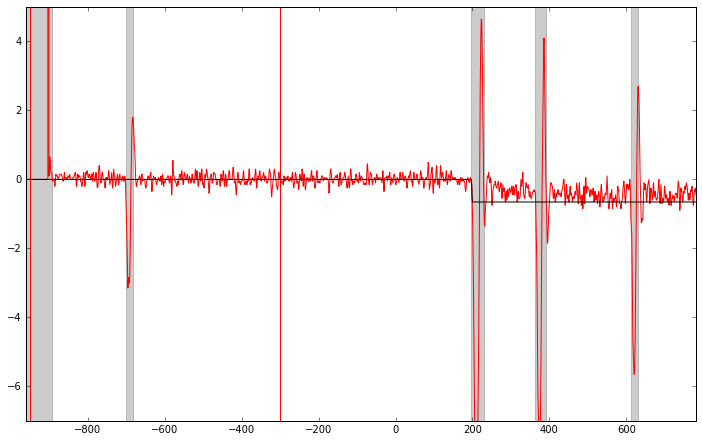

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))

ax.axis([StimulusOn-10, TargetOff+10, -7, 5])
ax.plot(trackertime, gradient_x, color='r')
#ax.plot(trackertime, out.init_fit, 'k--')
ax.plot(trackertime, out.best_fit, color='k')


for s in range(len(saccades)) :
    ax. axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

liste_l =[]
dir_bool = p[trial, block, 0]*2 - 1
for tps in range(len(trackertime)) :
    if dir_bool*out.best_fit[tps] >= 0.01 :
        liste_l.append(trackertime[tps])
if len(liste_l)!=0:
    latency = liste_l[0]
    ax.bar(latency, 12, bottom=-7, color='g', width=2, linewidth=0)
    print('latency = ', latency)
else:
    ax.text(StimulusOf+100, 3.5, "PAS DE latency !", color='r', fontsize=15)

# ax.text(StimulusOn+15, -7, "%s"%(out.fit_report()), color='k', fontsize=6)

ax.bar(StimulusOn, 12, bottom=-7, color='r', width=2, linewidth=0)
ax.bar(StimulusOf, 12, bottom=-7, color='r', width=2, linewidth=0)

ax.bar(TargetOn, 12, bottom=-7, color='k', width=2, linewidth=0)
ax.bar(TargetOff, 12, bottom=-7, color='k', width=2, linewidth=0)

**Ne marche pas super bien pour tous les essais**

# Test Fit -- Fonction Vitesse

In [9]:
def test_vitesse (x, tau=0.013, xT=0.01, t_T=0.9, start=1200.) :
    '''
    tau -- constante de l'oeuil (0.013)
    xT -- position en deg de la cible (1)
    t_T -- tps du mvt - s (0.1)
    start -- tps où commence le mvt
    '''
    
    dt = 0.001
    T = int(t_T/dt) # tps termine mvt - ms
    time = np.arange(len(x))/1000 # en seconde !!!

    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    rhoT = int(np.round(T*rho)) # tps accélération
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N
    x_max = Umax*tau*(1-np.exp(-1/tau*time[rhoT]))

    return  np.concatenate(((0*np.ones(len(time[0:int(start)])), Umax*tau*(1-np.exp(-1/tau*time[0:rhoT])), x_max*np.ones(len(time[rhoT+int(start):])))))

2091


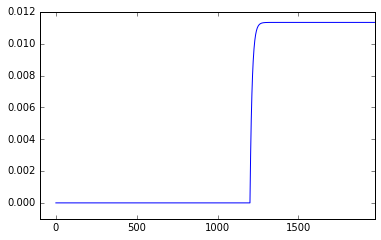

In [10]:
print(len(test_vitesse(trackertime)))

fig, ax = plt.subplots(1, 1, figsize=(6, (6/1.6180)))
ax.axis([0-100, len(trackertime)+100, -0.001, 0.012])
plt.plot(test_vitesse(trackertime))

## PROBLEME

**problème avec start** : ne se modifie pas (ou très peut) -- obliger de le rentrer à la main !

**Pose problème pour trouver la latency !**

[[Model]]
    Model(test_vitesse)
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 1870
    # variables        = 4
    chi-square         = 203041.736
    reduced chi-square = 108.811
    Akaike info crit   = 8773.575
    Bayesian info crit = 8795.710
[[Variables]]
    tau:     0.00444890 +/- 0        (0.00%) (init= 0.013)
    xT:      0.00140204 +/- 0        (0.00%) (init= 0.05)
    t_T:     0.19543288 +/- 0        (0.00%) (init= 0.1)
    start:   99.9999266 +/- 0        (0.00%) (init= 100)



<Container object of 1 artists>

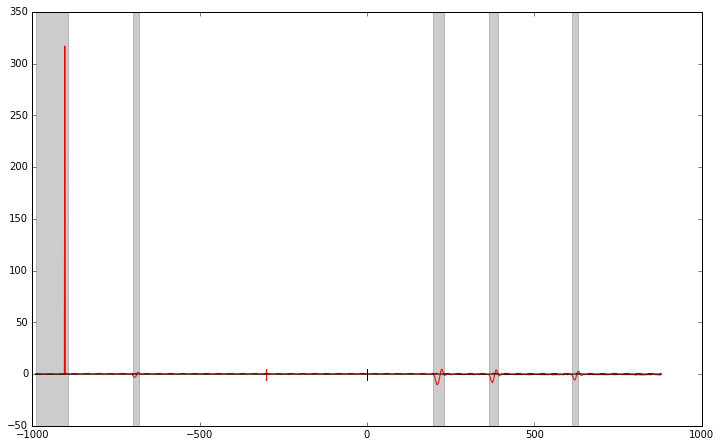

In [11]:
gradient_x = np.gradient(data_x)

model = Model(test_vitesse)

params = Parameters()
params.add('tau', value=0.013, min=0.001, max=0.1)#, vary=False)
params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.001, max=0.2)#, vary=False)
params.add('start', value=100., min=0, max=2000.)#, vary=True)

result = model.fit(gradient_x, params, x=trackertime)
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))

#ax.axis([StimulusOn-10, TargetOff+10, -7, 5])
ax.plot(trackertime, gradient_x, color='r')

ax.plot(trackertime, result.init_fit, 'g--')
ax.plot(trackertime, result.best_fit, 'k')

for s in range(len(saccades)) :
    ax. axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

ax.bar(StimulusOn, 12, bottom=-7, color='r', width=2, linewidth=0)
ax.bar(StimulusOf, 12, bottom=-7, color='r', width=2, linewidth=0)

ax.bar(TargetOn, 12, bottom=-7, color='k', width=2, linewidth=0)
ax.bar(TargetOff, 12, bottom=-7, color='k', width=2, linewidth=0)


# Résolution du problème

- changement de la fonction vitesse

le fit change enfin corectement le start

In [12]:
def vitesse (x, tau=0.013, xT=0.1, t_T=1, start=1200., bino=1) :

    '''
    tau -- constante temps oeuil (0.013)
    t_T -- tps du mvt - s (0.1)
    xT -- position en deg de la cible (1)
    start -- tps où commence le mvt
    bino -- binomial
    '''    
    
    if bino == 0:
        xT =xT*-1
        
    #dt = 0.001
    #T = int(t_T/dt) # tps termine mvt - ms
    
    time = np.arange(len(x))/1000 # en seconde !!!
    start = start/1000 # en seconde !!!
    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    
    #rhoT = int(np.round(T*rho)) # tps accélération
    
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N

    vitesse = []
    for t in range(len(time)):
        if bino==0 :
            if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) > 0 :
                vitesse.append(0)
            else :
                vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
        else :
            if Umax*tau*(1-np.exp(-1/tau*(time[t]-start))) < 0 :
                vitesse.append(0)
            else :
                vitesse.append(Umax*tau*(1-np.exp(-1/tau*(time[t]-start))))
    return vitesse

1870


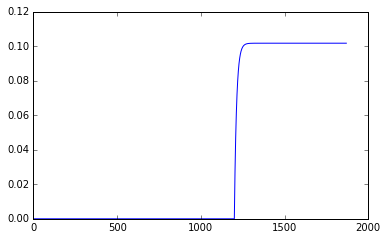

In [13]:
print(len(vitesse(trackertime)))

fig, ax = plt.subplots(1, 1, figsize=(6, (6/1.6180)))
plt.plot(vitesse(trackertime))

In [14]:
trial = 0
block = 0
trial_data = trial + N_trials*block

bino = p[trial, block, 0]

data_x = data[trial_data]['x']

trackertime = data[trial_data]['trackertime']
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']

start = TargetOn

StimulusOn = StimulusOn - start
StimulusOf = StimulusOf - start
TargetOn = TargetOn - start
TargetOff = TargetOff - start
trackertime = trackertime - start

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.5/dist-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


[[Model]]
    Model(vitesse)
[[Fit Statistics]]
    # function evals   = 130
    # data points      = 1870
    # variables        = 4
    chi-square         = 202744.683
    reduced chi-square = 108.652
    Akaike info crit   = 8770.837
    Bayesian info crit = 8792.972
[[Variables]]
    tau:     0.00103431 +/- 0.093325 (9022.98%) (init= 0.013)
    xT:      0.03160827 +/- 6.33e+05 (2002697768.02%) (init= 0.05)
    t_T:     0.04960053 +/- 9.66e+05 (1947949314.84%) (init= 0.1)
    start:   1187.44002 +/- 113.5440 (9.56%) (init= 1000)
    bino:    0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(xT, t_T)                   =  1.000 
    C(tau, start)                = -0.937 



<Container object of 1 artists>

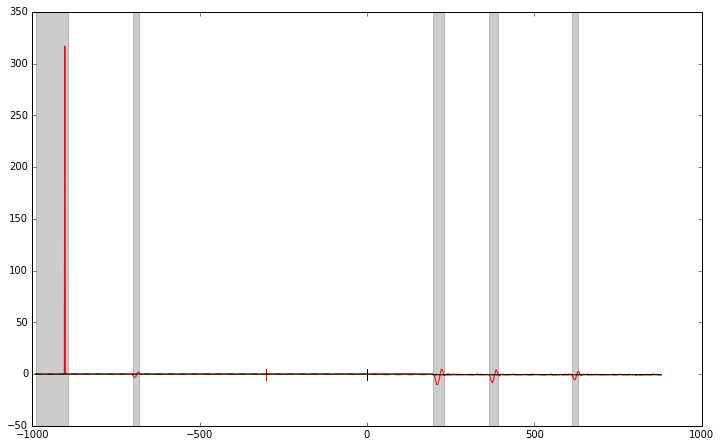

In [15]:
gradient_x = np.gradient(data_x)

model = Model(vitesse)

params = Parameters()
params.add('tau', value=0.013, min=0.001, max=0.1)#, vary=False)
params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.001, max=0.2)#, vary=False)
params.add('start', value=1000., min=0, max=2000.)#, vary=True)
params.add('bino', value=bino, min=0, max=1, vary=False)


result = model.fit(gradient_x, params, x=trackertime)
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))

#ax.axis([StimulusOn-10, TargetOff+10, -7, 5])
ax.plot(trackertime, gradient_x, color='r')

ax.plot(trackertime, result.init_fit, 'g--')
ax.plot(trackertime, result.best_fit, 'k')

for s in range(len(saccades)) :
    ax. axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

ax.bar(StimulusOn, 12, bottom=-7, color='r', width=2, linewidth=0)
ax.bar(StimulusOf, 12, bottom=-7, color='r', width=2, linewidth=0)

ax.bar(TargetOn, 12, bottom=-7, color='k', width=2, linewidth=0)
ax.bar(TargetOff, 12, bottom=-7, color='k', width=2, linewidth=0)


on doit maintenant supprimer les saccades afin de voir si cela marche vraiment correctement

# Test suppression Saccades

In [16]:
print(saccades)

[[796818, 796913, 96, 0.0, 0.0, 0.0, 0.0], [797107, 797125, 19, 643.0, 532.2, 622.9, 518.3], [798004, 798037, 34, 634.0, 513.6, 546.5, 507.4], [798170, 798199, 30, 503.8, 513.5, 442.3, 512.3], [798418, 798438, 21, 341.9, 509.1, 296.7, 506.0]]


In [17]:
new_data=[]
new_gradient_x=[]
new_time=[]

t=0
for x in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
            saccade = 'yes'
    if not saccade :
        new_data.append(data_x[x])
        new_gradient_x.append(gradient_x[x])
        new_time.append(t)
        t = t+1
    saccade = None

In [18]:
debut  = data[trial_data]['events']['msg'][15][0]-trackertime_0

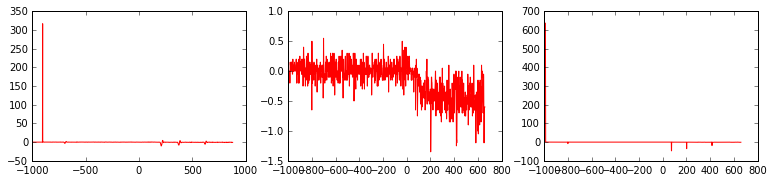

In [19]:
new_gradient_x2 = np.gradient(new_data)

fig, ax = plt.subplots(1, 3, figsize=(13, (13/(1.6180*3))))

ax[0].plot(trackertime, gradient_x, color='r')
ax[1].plot(np.asarray(new_time)-debut, new_gradient_x, color='r')
ax[2].plot(np.asarray(new_time)-debut, new_gradient_x2, color='r')

# Test Fit stepModel et fonction vitesse sur nouvelles données

In [20]:
debut  = data[trial_data]['events']['msg'][15][0]-trackertime_0
bino = p[trial, block, 0]

[[Model]]
    Model(step, form='erf')
[[Fit Statistics]]
    # function evals   = 55
    # data points      = 1650
    # variables        = 3
    chi-square         = 52.361
    reduced chi-square = 0.032
    Akaike info crit   = -5687.121
    Bayesian info crit = -5670.896
[[Variables]]
    sigma:       80.9934629 +/- 11.47587 (14.17%) (init= 235.5714)
    amplitude:  -0.45890235 +/- 0.008578 (1.87%) (init= 1.9)
    center:      1102.27205 +/- 5.850729 (0.53%) (init= 824.5)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, center)         = -0.324 
    C(sigma, amplitude)          = -0.264 

latency =  -51


<Container object of 1 artists>

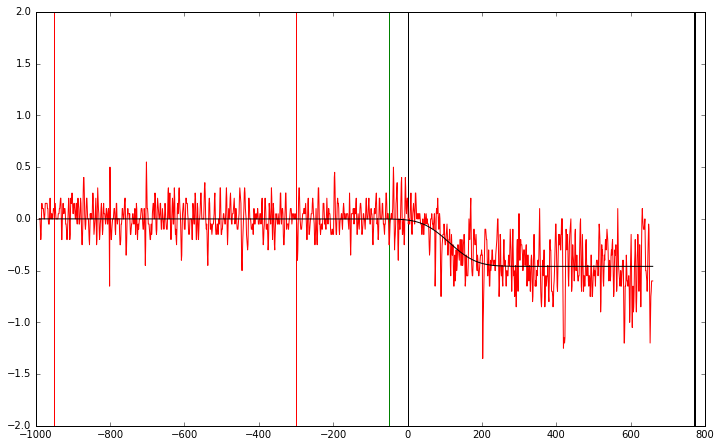

In [21]:
mod =  StepModel(form='erf')
pars = mod.guess(new_gradient_x, x=new_time) 
out = mod.fit(new_gradient_x, pars, x=new_time)

print(out.fit_report())

fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))

ax.plot(np.asarray(new_time)-debut, new_gradient_x, color='r')
#ax.plot(np.asarray(new_time)-debut, out.init_fit, 'k--')
ax.plot(np.asarray(new_time)-debut, out.best_fit, color='k')

liste_l =[]
dir_bool = bino*2 - 1
for tps in range(len(new_time)) :
    if dir_bool*out.best_fit[tps] > 0.001 :
        liste_l.append(new_time[tps])
if len(liste_l)!=0:
    latency = liste_l[0]
    ax.bar(latency-debut, 4, bottom=-2, color='g', width=5, linewidth=0)
    print('latency = ', latency-debut)
else:
    ax.text(StimulusOf+10, 1.5, "PAS DE latency !", color='r', fontsize=15)

# ax.text(StimulusOn+15, -7, "%s"%(out.fit_report()), color='k', fontsize=6)


ax.bar(StimulusOn, 4, bottom=-2, color='r', width=4, linewidth=0)
ax.bar(StimulusOf, 4, bottom=-2, color='r', width=4, linewidth=0)

ax.bar(TargetOn, 4, bottom=-2, color='k', width=4, linewidth=0)
ax.bar(TargetOff, 4, bottom=-2, color='k', width=4, linewidth=0)

[[Model]]
    Model(vitesse)
[[Fit Statistics]]
    # function evals   = 45
    # data points      = 1650
    # variables        = 4
    chi-square         = 51.907
    reduced chi-square = 0.032
    Akaike info crit   = -5699.491
    Bayesian info crit = -5677.857
[[Variables]]
    tau:     0.09999993 +/- nan      (nan%) (init= 0.013)
    xT:      0.03554096 +/- nan      (nan%) (init= 0.05)
    t_T:     0.18288152 +/- nan      (nan%) (init= 0.1)
    start:   1027.33101 +/- 0        (0.00%) (init= 1000)
    bino:    0 (fixed)

latency =  37.3310193537
new_latency = 152.331019354


/usr/local/lib/python3.5/dist-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


<Container object of 1 artists>

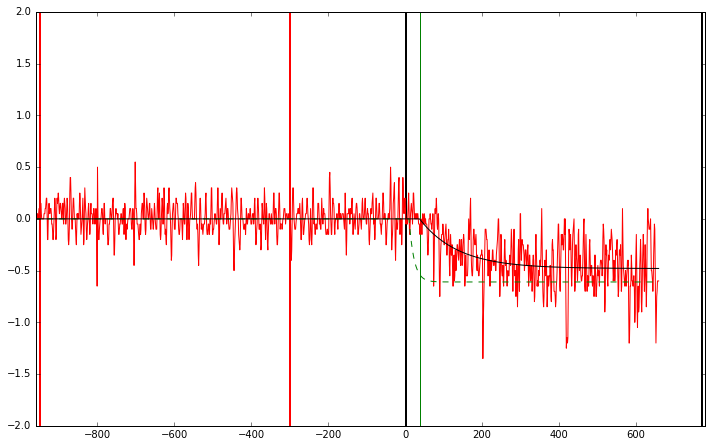

In [22]:
model = Model(vitesse)

params = Parameters()
params.add('tau', value=0.013, min=0.001, max=0.1)#, vary=False)
params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.001, max=0.2)#, vary=False)
params.add('start', value=1000., min=0, max=2000.)#, vary=True)
params.add('bino', value=bino, min=0, max=1, vary=False)

result = model.fit(new_gradient_x, params, x=new_time)
print(result.fit_report())

latency = result.values['start']
print('latency = ', latency-debut)

new_latency = latency
for s in range(len(saccades)) :
    if new_latency > saccades[s][0]-trackertime_0 :
        new_latency = new_latency + saccades[s][2]
print('new_latency =', new_latency-debut)


fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))


ax.axis([StimulusOn-10, TargetOff+10, -2, 2])
ax.plot(np.asarray(new_time)-debut, new_gradient_x, color='r')

ax.plot(np.asarray(new_time)-debut, result.init_fit, 'g--')
ax.plot(np.asarray(new_time)-debut, result.best_fit, 'k')

ax.bar(latency-debut, 4, bottom=-2, color='g', width=4, linewidth=0)

#ax.text(StimulusOn+15, -7, "%s"%(out.fit_report()), color='k', fontsize=6)


ax.bar(StimulusOn, 4, bottom=-2, color='r', width=4, linewidth=0)
ax.bar(StimulusOf, 4, bottom=-2, color='r', width=4, linewidth=0)

ax.bar(TargetOn, 4, bottom=-2, color='k', width=4, linewidth=0)
ax.bar(TargetOff, 4, bottom=-2, color='k', width=4, linewidth=0)

## Without varying eye parameters

[[Model]]
    Model(vitesse)
[[Fit Statistics]]
    # function evals   = 39
    # data points      = 1650
    # variables        = 2
    chi-square         = 53.202
    reduced chi-square = 0.032
    Akaike info crit   = -5662.832
    Bayesian info crit = -5652.015
[[Variables]]
    tau:     0.013 (fixed)
    xT:      0.03602307 +/- 0.000628 (1.74%) (init= 0.05)
    t_T:     0.1 (fixed)
    start:   1072.61338 +/- 2.079229 (0.19%) (init= 1000)
    bino:    0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(xT, start)                 =  0.107 

latency =  82.6133867978
new_latency = 231.613386798


/usr/local/lib/python3.5/dist-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


<Container object of 1 artists>

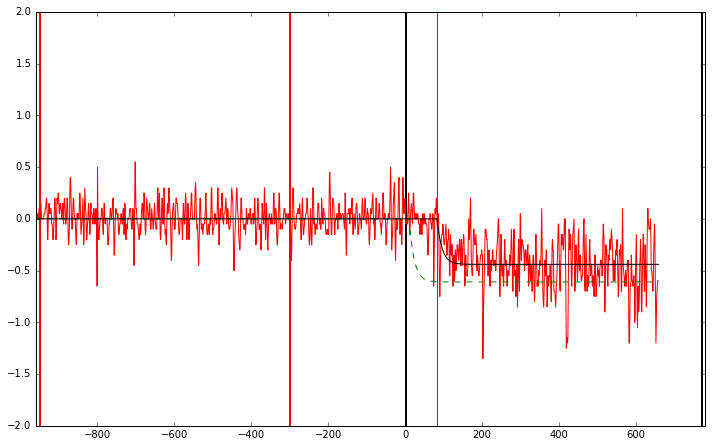

In [23]:
model = Model(vitesse)

params = Parameters()
params.add('tau', value=0.013, min=0.001, max=0.1, vary=False)
params.add('xT', value=0.05, min=0.001, max=0.1)#, vary=False)
params.add('t_T', value= 0.1, min=0.001, max=0.2, vary=False)
params.add('start', value=1000., min=0, max=2000.)#, vary=True)
params.add('bino', value=bino, min=0, max=1, vary=False)

result = model.fit(new_gradient_x, params, x=new_time)
print(result.fit_report())

latency = result.values['start']
print('latency = ', latency-debut)

new_latency = latency
for s in range(len(saccades)) :
    if new_latency > saccades[s][0]-trackertime_0 :
        new_latency = new_latency + saccades[s][2]
print('new_latency =', new_latency-debut)

fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))


ax.axis([StimulusOn-10, TargetOff+10, -2, 2])
ax.plot(np.asarray(new_time)-debut, new_gradient_x, color='r')

ax.plot(np.asarray(new_time)-debut, result.init_fit, 'g--')
ax.plot(np.asarray(new_time)-debut, result.best_fit, 'k')

ax.bar(latency-debut, 4, bottom=-2, color='g', width=4, linewidth=0)


#ax.text(StimulusOn+15, -7, "%s"%(out.fit_report()), color='k', fontsize=6)


ax.bar(StimulusOn, 4, bottom=-2, color='r', width=4, linewidth=0)
ax.bar(StimulusOf, 4, bottom=-2, color='r', width=4, linewidth=0)

ax.bar(TargetOn, 4, bottom=-2, color='k', width=4, linewidth=0)
ax.bar(TargetOff, 4, bottom=-2, color='k', width=4, linewidth=0)